<div>
<h3>Suggestion Mining</h3>
<p>It can be defined as the automatic extraction of suggestions from unstructured text, where the term <i>suggestion</i> refers to the expression of tips, advice, recommendations etc. As proposed by Negi et. al. <a href = "#paper1"> [1] </a>, the scope of suggestions is limited to explicit suggestions only. These are the sentences for which the surface structure as well as the context conform to a suggestion.</p>

<h4> Problem Statement </h4>
<p>Given a sentence <i>s</i>. If <i>s</i> is an explicit suggestion, assign the label <i>'suggestion'</i>. Otherwise, assign the label <i>'non-suggestion'</i>.</p>

<h4> Data </h4>
<p>This notebook uses the <a href = "https://github.com/Semeval2019Task9/Subtask-A"> Semeval 2019 Subtask-A</a> dataset, which contains sentences from Microsoft Windows App Studio discussion forum.</p>

<h4> Contents </h4>
<ol>
    <li> <a href = "#eda"> Exploratory Data Analysis </a> </li>
    <li> <a href = "#fe"> Feature Engineering </a> </li>
    <li> <a href = "#statmod"> Statistical Models </a> </li>
    <li> <a href = "#gbdtmod"> Gradient Boosting Decision Tree Ensemble Models </a> </li>
    <li> <a href = "#dlmod"> Deep Learning Model </a> </li>
    <li> <a href = "#stackmod"> Stacking Models </a> </li>
</ol>

<h4> References</h4>
This notebook contains theoretic and implementation ideas from the following research papers:<br/>
<ol>
    <li><a href = "https://arxiv.org/abs/1806.02179" id = "paper1"> Open Domain Suggestion Mining: Problem Definition and Datasets</a>. Sapna Negi, Maarten de Rijke, and Paul Buitelaar. arXiv preprint arXiv:1806.02179 (2018).</li>
    <li><a href = "https://aclweb.org/anthology/S/S16/S16-2022.pdf" id = "paper2"> A Study of Suggestions in Opinionated Texts and their automatic Detection </a>. Sapna Negi, Kartik Asooja, Shubham Mehrotra, Paul Buitelaar. *SEM 2016, Co-located with ACL 2016, Berlin, Germany.</li>
<li><a href = "https://arxiv.org/pdf/1709.07403.pdf" id = "paper3"> Inducing Distant Supervision in Suggestion Mining through Part-of-Speech Embeddings </a>. Sapna Negi, and Paul Buitelaar. arXiv preprint arXiv:1709.07403 (2017).</li>
</ol>
</div>

In [1]:
# import required packages

import pandas as pd 
import numpy as np
import os, gc, time, warnings

from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
import pydot, graphviz
from IPython.display import Image

import string, re, nltk, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
# settings

os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
ps = PorterStemmer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [3]:
# import the dataset

train = pd.read_csv("../input/midasiiitd/V1.4_Training.csv", encoding = 'latin-1')
dev = pd.read_csv("../input/midasiiitd/SubtaskA_Trial_Test_Labeled.csv", encoding = 'latin-1')
test = pd.read_csv("../input/midasiiitd/SubtaskA_EvaluationData.csv", encoding = 'latin-1')

<div><h3 id = "eda"> Exploratory Data Analysis </h3></div>

<div>
    <p> There are three columns in the training data. The first column is 'id' which is a unique identifier for each sentence. The second column 'sentence' contains exactly one sentence as a string of characters. The third column is the target variable 'label', which is an integer that has value 1 if the corresponding sentence is a suggestion, and 0 otherwise. <b>There are no missing values in the entire training set.</b></p></div>

In [4]:
# quick look at a few training examples

train.head(10)

,id,sentence,label
0,663_3,"""Please enable removing language code from the...",1
1,663_4,"""Note: in your .csproj file, there is a Suppor...",0
2,664_1,"""Wich means the new version not fully replaced...",0
3,664_2,"""Some of my users will still receive the old x...",0
4,664_3,"""The store randomly gives the old xap or the n...",0
5,664_4,"""My app has a WP7 version and a WP8 version XA...",0
6,664_5,"""The wp7 xap works only on WP7 and the wp8 xap...",0
7,665_1,"""Sometimes the Store gives the wrong wp7 xap v...",0
8,665_2,"""It should be an option to remove the ""ru"" lan...",1
9,665_3,"""Currently if you ever mistakenly selected a ""...",0


In [5]:
print("Training data...")
train.info()

Training data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 3 columns):
id          8500 non-null object
sentence    8500 non-null object
label       8500 non-null int64
dtypes: int64(1), object(2)
memory usage: 199.3+ KB


In [6]:
# class-imbalance in training data

suggestion_count = (train['label'].values == 1).astype(int).sum()
non_suggestion_count = (train['label'].values == 0).astype(int).sum()
print("Total sentences : " + str(train.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total non_suggestions : " + str(non_suggestion_count))

Total sentences : 8500
Total suggestions : 2085
Total non_suggestions : 6415


<div>
    <p> There exists a significant class imbalance in the training data. Paper <a href = "#paper3"> [3] </a> addresses the issue of class imbalance in data. It suggests oversampling to achieve class balance. In oversampling, multiple copies of instances of the minority class are created till a balance is achieved. The results show that balanced data is better for both domain specific and domain independent training.</p>
    </div>

In [7]:
# oversampling to balance the training data

suggestions = train[train['label'].values == 1]

while suggestion_count < non_suggestion_count:
    random_suggestion = suggestions.sample()
    train = train.append(random_suggestion, ignore_index = True)
    suggestion_count = suggestion_count + 1

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12830 entries, 0 to 12829
Data columns (total 3 columns):
id          12830 non-null object
sentence    12830 non-null object
label       12830 non-null int64
dtypes: int64(1), object(2)
memory usage: 300.8+ KB


In [8]:
# exploring the development/validation data

print("Development Set...")
dev.info()

Development Set...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 3 columns):
id          592 non-null object
sentence    592 non-null object
label       592 non-null int64
dtypes: int64(1), object(2)
memory usage: 14.0+ KB


In [9]:
# class-imbalance in development data

suggestion_count = (dev['label'].values == 1).astype(int).sum()
non_suggestion_count = (dev['label'].values == 0).astype(int).sum()
print("Total sentences : " + str(dev.shape[0]))
print("Total suggestions : " + str(suggestion_count))
print("Total non_suggestions : " + str(non_suggestion_count))

Total sentences : 592
Total suggestions : 296
Total non_suggestions : 296


<div><p>There is no class imbalance in the development set.</p></div>

<div>
<h4> Word Clouds for the two target classes </h4>
<p> Word clouds are a visual representation of the frequency of occurence of several words and phrases in a corpus. The font size of a word or a phrase appearning in a word cloud is directly proportional to its number of occurences in the corpus.</p>     
</div>

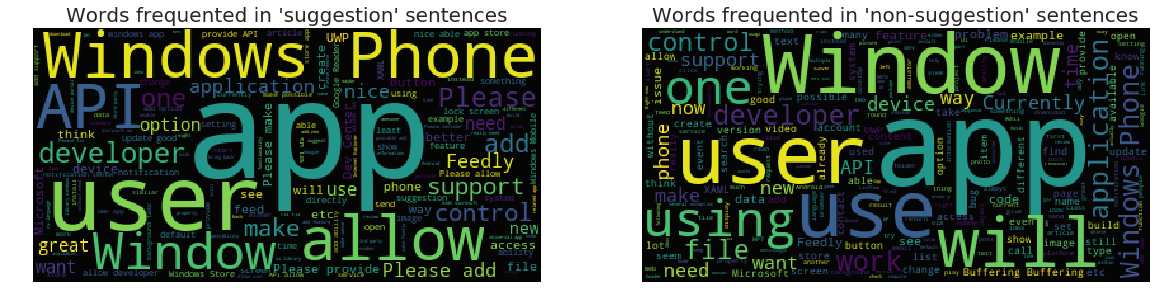

In [10]:
stopword = set(STOPWORDS)

# wordcloud for sentences with 'suggestion' label
subset = train[train.label == 1]
content = subset.sentence.values
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(content))
plt.figure(figsize = (20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in 'suggestion' sentences", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

# wordcloud for sentences with 'non-suggestion' label
subset = train[train.label == 0]
content = subset.sentence.values
wc = WordCloud(background_color = "black", max_words = 2000, stopwords = stopword)
wc.generate(" ".join(content))
plt.subplot(222)
plt.axis("off")
plt.title("Words frequented in 'non-suggestion' sentences", fontsize = 20)
plt.imshow(wc.recolor(colormap = 'viridis', random_state = 17), alpha = 0.98)

plt.show()

<div>
<p>
The word clouds do not render any significant difference between the type of words occuring frequently in the two classes.  The top unigrams in the 'suggestion' class like 'Window', 'app', 'user', 'developer', 'Windows Phone', 'use', 'need' and 'new' also occur frequently in the 'non-suggestion' class.<br/>
    Refering to the description of linguistic observations in explicit suggestions in paper <a href = "#paper1"> [1] </a>, in this dataset, the suggestion sentences do not contain frequent occurence of keywords and pharases directly expressing suggestions, like 'suggest', 'suggestion', 'recommendation', 'advice', 'I suggest', 'I recommend', etc. <br/> 
    Let's take a look at the top bigrams in the two classes to further see the difference.
</p>
</div>

In [11]:
# Aphost lookup dict

APPO = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

In [12]:
def clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*>', '', sentence)
    sentence = re.sub("\\n", "", sentence)
    sentence = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", sentence)
    sentence = re.sub("\[\[.*\]", "", sentence)
    sentence = re.sub("[" + re.sub("\.","",string.punctuation) + "]", "", sentence)
    
    words = tokenizer.tokenize(sentence)
    
    words = [APPO[word] if word in APPO else word for word in words]
    words = [ps.stem(word) for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent = " ".join(words)
    
    return(clean_sent)

In [13]:
# obtaining separate clean corpora for suggestion and non-suggestion classes

suggestion_corpus = train[train['label'].values == 1].sentence
suggestion_corpus = suggestion_corpus.append(dev[dev['label'].values == 1].sentence)
clean_suggestion_corpus = ""
for sentence in suggestion_corpus:
    clean_suggestion_corpus += clean(sentence)

non_suggestion_corpus = train[train['label'].values == 0].sentence
non_suggestion_corpus = non_suggestion_corpus.append(dev[dev['label'].values == 0].sentence)
clean_non_suggestion_corpus = ""
for sentence in non_suggestion_corpus:
    clean_non_suggestion_corpus += clean(sentence)

In [14]:
# top 20 bigrams in suggestion sentences

suggestion_bigrams = ngrams(clean_suggestion_corpus.split(), 2)
suggestion_bigrams_freq = collections.Counter(suggestion_bigrams)
suggestion_bigrams_freq.most_common(20)

[(('window', 'phone'), 270),
 (('would', 'like'), 122),
 (('like', 'see'), 93),
 (('would', 'nice'), 89),
 (('window', '10'), 85),
 (('would', 'great'), 81),
 (('someth', 'like'), 57),
 (('dev', 'center'), 53),
 (('like', 'abl'), 53),
 (('nice', 'abl'), 49),
 (('great', 'could'), 47),
 (('app', 'store'), 45),
 (('provid', 'api'), 41),
 (('api', 'allow'), 40),
 (('allow', 'user'), 39),
 (('allow', 'us'), 38),
 (('phone', '81'), 35),
 (('allow', 'develop'), 35),
 (('app', 'could'), 35),
 (('window', 'app'), 34)]

In [15]:
# top 20 bigrams in non-suggestion sentences

non_suggestion_bigrams = ngrams(clean_non_suggestion_corpus.split(), 2)
non_suggestion_bigrams_freq = collections.Counter(non_suggestion_bigrams)
non_suggestion_bigrams_freq.most_common(20)

[(('window', 'phone'), 173),
 (('window', '10'), 90),
 (('â', '\x80'), 90),
 (('¢', 'â'), 84),
 (('\x80', 'â'), 84),
 (('uwp', 'app'), 45),
 (('app', 'use'), 33),
 (('app', 'store'), 30),
 (('app', 'window'), 29),
 (('window', 'store'), 27),
 (('thi', 'issu'), 26),
 (('would', 'allow'), 26),
 (('desktop', 'bridg'), 26),
 (('creator', 'updat'), 25),
 (('phone', '8'), 23),
 (('thi', 'featur'), 22),
 (('phone', '81'), 21),
 (('would', 'like'), 21),
 (('phone', '7'), 21),
 (('win', '10'), 21)]

In [16]:
del(suggestions)
del(subset)
del(content)
del(stopword)
del(wc)
del(suggestion_corpus)
del(clean_suggestion_corpus)
del(non_suggestion_corpus)
del(clean_non_suggestion_corpus)
gc.collect()

0

<div>
<p> The suggestion bigrams have more frequent occurences of indirect suggestion expressing phrases like 'would like', 'would nice', 'would great'. These phrases contain an auxiliary verb followed by a verb or an adjective. We may think of extracting some useful feature based on these patterns. However, such constructs also appear in the non-suggestion sentences, as is apparent from the non-suggestion bigrams. Also, given the fact that we have oversampled the positive class to balance the data, it will not be a great idea to extract features based on these bigram patterns. 
<br/>
    The statistical models cannot learn the syntactic structure of sentences on their own. But, neural networks can. As suggested in paper <a href = "#paper3"> [3] </a>, we will use Part Of Speech (POS) embeddings to improve the syntactic structure learning by the deep learning models.
</p>
</div>

<div>
    <p> Finally, let's see how the length of sentences are related to their labels.
    </p>
</div>

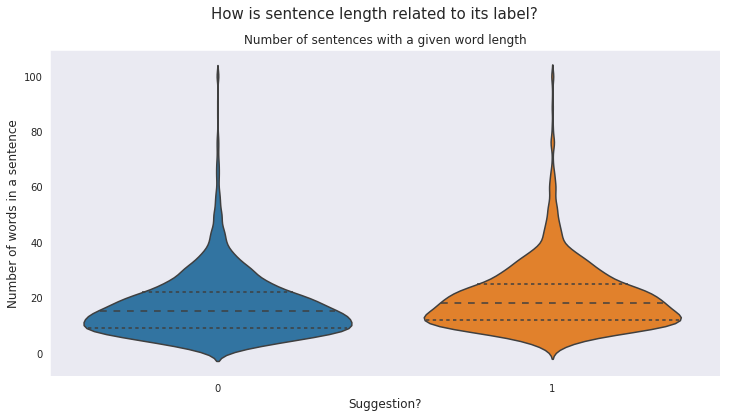

2100

In [17]:
# plot of sentence length against label

df = pd.concat([train, dev])
df['count_word'] = df['sentence'].apply(lambda x : len(x.split()))

plt.figure(figsize = (12, 6))
plt.suptitle("How is sentence length related to its label?", fontsize = 15)
count_word = df['count_word'].astype(int)
df['count_word'].loc[df['count_word'] > 100] = 100
plt.plot()
sns.violinplot(y = 'count_word', x = 'label', data = df, split = True, inner = "quart")
plt.xlabel('Suggestion?', fontsize = 12)
plt.ylabel('Number of words in a sentence', fontsize = 12)
plt.title("Number of sentences with a given word length", fontsize = 12)
plt.show()

del(df)
gc.collect()

<div>
    <p> It can be seen from the above plot that both suggestion and non-suggestion classes have similar frequency distribution of sentences having a given number of words, so it will be unwise to label a sentence as suggestion or non-suggestion based on the number of words in it.
    </p>
</div>

<div><p>
Another measure that can be checked for is the mean word length. The writers may choose more elegant and longer words for expressing suggestions. 
    </p></div>

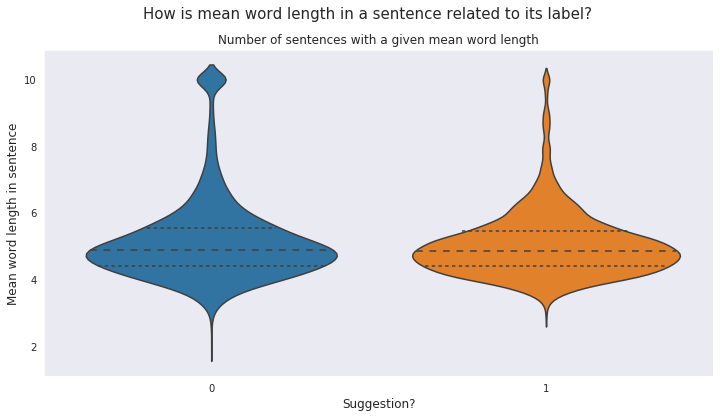

2040

In [18]:
# plot of mean word length against label

df = pd.concat([train, dev])
df['mean_word_len'] = df['sentence'].apply(lambda x : np.mean([len(word) for word in x.split()]))

plt.figure(figsize = (12, 6))
plt.suptitle("How is mean word length in a sentence related to its label?", fontsize = 15)
mean_word_len = df['mean_word_len'].astype(int)
df['mean_word_len'].loc[df['mean_word_len'] > 10] = 10
plt.plot()
sns.violinplot(y = 'mean_word_len', x = 'label', data = df, split = True, inner = "quart")
plt.xlabel('Suggestion?', fontsize = 12)
plt.ylabel('Mean word length in sentence', fontsize = 12)
plt.title("Number of sentences with a given mean word length", fontsize = 12)
plt.show()

del(df)
gc.collect()

<div><p>
    Mean word length analysis too does not yield any significant difference between the sentences in the two classes.
    </p>
</div>

<div>
<h3 id="fe"> Feature Engineering </h3>
<p> We extract certain useful features from the data which may improve the prediction performance of our statistical models.<br/>
    As is evident from the above analysis, the features related to the frequency of words may not be useful in this particular case. This may be very domain specific, since users on developers' forums are often very concise, less verbose and use more technical terms while writing all kind of sentences.<br/>
    Although, the ngram features too do not seem to differentiate between the sentences in the two classes very well, using these to learn syntactic structure of sentences may improve performances of our statistical models.<br/>
    We need not use these additional features, other than the word embeddings for sequence representation, with deep learning models since the neural networks can learn better feature representations on their own.
</div>

In [19]:
# corpus containing all the sentences in train, development and test data

corpus = (pd.concat([train.iloc[:, 0:2], dev.iloc[:, 0:2], test.iloc[:, 0:2]])).sentence
clean_corpus = corpus.apply(lambda x : clean(x))

In [20]:
# tf-idf vectors with unigram features

unigram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (1,1),
                              sublinear_tf = 1, stop_words = 'english')
unigram_tfv.fit(clean_corpus)

train_unigrams = unigram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_unigrams = unigram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])
test_unigrams = unigram_tfv.transform(clean_corpus.iloc[train.shape[0]+dev.shape[0]:])

In [21]:
# tf-idf vectors with bigram and trigram features

btgram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'word', ngram_range = (2,3),
            sublinear_tf = 1, stop_words = 'english')
btgram_tfv.fit(clean_corpus)

train_btgrams = btgram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_btgrams = btgram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])
test_btgrams = btgram_tfv.transform(clean_corpus.iloc[train.shape[0]+dev.shape[0]:])

In [22]:
# tf-idf vectors with char n-gram features

charngram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'char', ngram_range = (1,5),
                sublinear_tf = 1, stop_words = 'english')
charngram_tfv.fit(clean_corpus)

train_charngrams =  charngram_tfv.transform(clean_corpus.iloc[:train.shape[0]])
dev_charngrams = charngram_tfv.transform(clean_corpus.iloc[train.shape[0]:train.shape[0]+dev.shape[0]])
test_charngrams = charngram_tfv.transform(clean_corpus.iloc[train.shape[0]+dev.shape[0]:])

<div>
    <h3>Evaluation Metrics</h3>
    <p> We will use three different evaluation metrics : Precision score, Recall score and F1 score. The F1 score can be interpreted as a weighted average of the Precision and Recall. These three metrics have been used in paper <a href = "#paper2"> [2] </a>.  </p>
</div>

In [23]:
# evaluation functions for different models

def lgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.4).astype(int)
    return 'f1_score', f1_score(y_train, preds), True

def xgb_f1_score(preds, train_data):
    y_train = train_data.get_label()
    preds = (preds >= 0.4).astype(int)
    return 'f1_score', f1_score(y_train, preds)

def nn_f1_score(y_true, y_pred):
    y_pred = tf.cast((y_pred >= 0.4), tf.float32)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis = 0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis = 0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis = 0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis = 0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1_score = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1_score)

<div>
    <h3 id = "statmod"> Statistical Models </h3>
    <p> We will train two statistical models : Logistic Regression and Support Vector Machine (SVM).</p>
</div>

In [24]:
# preparing data for statistical and GBDT models

x_train = hstack((train_unigrams, train_btgrams, train_charngrams)).tocsr()
y_train = train['label'].values
x_dev = hstack((dev_unigrams, dev_btgrams, dev_charngrams)).tocsr()
y_dev = dev['label'].values
x_test = hstack((test_unigrams, test_btgrams, test_charngrams)).tocsr()

In [25]:
# logistic regression classifier

clf = LogisticRegression(C = 0.1, solver = 'liblinear')
clf.fit(x_train, y_train)

lr_dev_pred = clf.predict_proba(x_dev)[:, 1]
lr_test_pred = clf.predict_proba(x_test)[:, 1]

y_pred = (lr_dev_pred >= 0.4).astype(int)
lr_precision = precision_score(y_dev, y_pred)
lr_recall = recall_score(y_dev, y_pred)
lr_f1 = f1_score(y_dev, y_pred)

print("Logistic Regression...")
print("Precision score : " + str(lr_precision))
print("Recall score : " + str(lr_recall))
print("F1 score : " + str(lr_f1))

Logistic Regression...
Precision score : 0.6596306068601583
Recall score : 0.8445945945945946
F1 score : 0.7407407407407408


In [26]:
# SVM classifier

# reducing the number of features using Singular Value Decomposition
svd = TruncatedSVD(n_components = 15)
svd.fit(vstack((x_train, x_dev, x_test)).tocsr())
x_train_svd = svd.transform(x_train)
x_dev_svd = svd.transform(x_dev)
x_test_svd = svd.transform(x_test)

# scaling the data obtained from SVD
scaler = StandardScaler()
scaler.fit(np.concatenate((x_train_svd, x_dev_svd, x_test_svd)))
x_train_svd = scaler.transform(x_train_svd)
x_dev_svd = scaler.transform(x_dev_svd)
x_test_svd = scaler.transform(x_test_svd)

clf = SVC(C = 0.1, probability = True)
clf.fit(x_train_svd, y_train)

svm_dev_pred = clf.predict_proba(x_dev_svd)[:, 1]
svm_test_pred = clf.predict_proba(x_test_svd)[:, 1]

y_pred = (svm_dev_pred >= 0.4).astype(int)
svm_precision = precision_score(y_dev, y_pred)
svm_recall = recall_score(y_dev, y_pred)
svm_f1 = f1_score(y_dev, y_pred)

print("SVM Classifier...")
print("Precision score : " + str(svm_precision))
print("Recall score : " + str(svm_recall))
print("F1 score : " + str(svm_f1))

SVM Classifier...
Precision score : 0.6617210682492581
Recall score : 0.7533783783783784
F1 score : 0.7045813586097947


<div>
    <h3 id = "gbdtmod"> Gradient Boosting Decision Tree Ensemble Models </h3>
    <p>We will train two high performing GBDT models : LGBM and XGBoost.</p>
</div>

In [27]:
# lgbm classifier

import lightgbm as lgb

d_train = lgb.Dataset(x_train, label = y_train)
d_dev = lgb.Dataset(x_dev, label = y_dev)
valid_sets = [d_train, d_dev]

params = {'learning_rate': 0.2,
          'application': 'binary',
          'num_leaves': 31,
          'verbosity': -1,
          'bagging_fraction': 0.8,
          'feature_fraction': 0.6,
          'nthread': 4,
          'lambda_l1': 1,
          'lambda_l2': 1}

model = lgb.train(params,
                  train_set = d_train,
                  num_boost_round = 25,
                  valid_sets = valid_sets,
                  feval = lgb_f1_score,
                  verbose_eval = False)

lgb_dev_pred = model.predict(x_dev)
lgb_test_pred = model.predict(x_test)

y_pred = (lgb_dev_pred >= 0.4).astype(int)
lgb_precision = precision_score(y_dev, y_pred)
lgb_recall = recall_score(y_dev, y_pred)
lgb_f1 = f1_score(y_dev, y_pred)

print("LGBM Classifier...")
print("Precision score : " + str(lgb_precision))
print("Recall score : " + str(lgb_recall))
print("F1 score : " + str(lgb_f1))

LGBM Classifier...
Precision score : 0.7138364779874213
Recall score : 0.7668918918918919
F1 score : 0.739413680781759


In [28]:
del(d_train)
del(d_dev)
del(model)
gc.collect()

306

In [29]:
# XGBoost classifier

import xgboost as xgb

d_train = xgb.DMatrix(x_train, label = y_train)
d_dev = xgb.DMatrix(x_dev, label = y_dev)
d_test = xgb.DMatrix(x_test)
evallist = [(d_train, 'train'), (d_dev, 'valid')]

params = {'booster' : 'gbtree',
          'nthread' : 4,
          'eta' : 0.2,
          'max_depth' : 6,
          'min_child_weight' : 4,
          'subsample' : 0.7,
          'colsample_bytree' : 0.7,
          'objective' : 'binary:logistic'}

model = xgb.train(params, 
                  d_train, 
                  num_boost_round = 21,
                  evals = evallist,
                  feval = xgb_f1_score,
                  verbose_eval = False)

xgb_dev_pred = model.predict(d_dev, ntree_limit = 21)
xgb_test_pred = model.predict(d_test, ntree_limit = 21)

y_pred = (xgb_dev_pred >= 0.4).astype(int)
xgb_precision = precision_score(y_dev, y_pred)
xgb_recall = recall_score(y_dev, y_pred)
xgb_f1 = f1_score(y_dev, y_pred)

print("XGBoost Classifier...")
print("Precision score : " + str(xgb_precision))
print("Recall score : " + str(xgb_recall))
print("F1 score : " + str(xgb_f1))

XGBoost Classifier...
Precision score : 0.7083333333333334
Recall score : 0.7466216216216216
F1 score : 0.7269736842105262


In [30]:
del(x_train)
del(y_train)
del(x_dev)
del(y_dev)
del(d_train)
del(d_dev)
del(model)
gc.collect()

232

<div>
    <h3 id = "dlmod"> Deep Learning Model </h3>
    <p> Paper <a href = "#paper2"> [2] </a> uses two different Neural Network models namely Long Short-Term Memory (LSTM), which is a variant of Recurrent Neural Network (RNN), and Convolutional Neural Network (CNN). For learning sequences, they have used word embeddings generated from three different pre-trained models - COMPOSES7, Glove and DEPS. Paper <a href = "#paper3"> [3] </a> introduced additional Part Of Speech (POS) embeddings, and an increase in prediction performace was observed on using these.<br/><br/>
        We will develop a hybrid Deep Neural Network architecture containing Gated Recurrent Unit (GRU) units as well as Convolutional layers. The reason we use GRU and not LSTM is that the lengths of word sequences in our dataset are quite small, average length being 19 words. GRU is faster than LSTM and known to perform better with smaller length sequences. In the recent years, Facebook's <a href = "https://www.kaggle.com/facebook/fasttext-wikinews"> fastText </a> library has shown better performance at learning word representation than other pre-trained models. So, we will use this library for generating word embeddings and POS embeddings. 
        
    </p>
</div>

In [31]:
# preparing data for Neural Network

EMBEDDING_FILE = '../input/fasttext/crawl-300d-2M.vec'

max_features = 10760
maxlen = 600
embed_size = 300

pos_tags_train = train['sentence'].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values
pos_tags_dev = dev['sentence'].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values
pos_tags_test = test['sentence'].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values

x_train = train['sentence'].values + " " + pos_tags_train
y_train = train['label'].values
x_dev = dev['sentence'].values + " " + pos_tags_dev
y_dev = dev['label'].values
x_test = test['sentence'].values + " " + pos_tags_test

tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(x_train) + list(x_dev) + list(x_test))
x_train = tokenizer.texts_to_sequences(x_train)
x_dev = tokenizer.texts_to_sequences(x_dev)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_dev = sequence.pad_sequences(x_dev, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype = 'float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
# Hybrid Neural Network classifier

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size, weights = [embedding_matrix])(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(100, return_sequences = True))(x)
x = Conv1D(50, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(1, activation = "sigmoid")(conc)
    
model = Model(inputs = inp, outputs = outp)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [nn_f1_score])
model.fit(x_train, y_train, batch_size = 128, epochs = 1, validation_data = (x_dev, y_dev), verbose = 1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12830 samples, validate on 592 samples
Epoch 1/1
12830/12830 [==============================] - 201s 16ms/step - loss: 0.4549 - nn_f1_score: 0.7987 - val_loss: 0.4416 - val_nn_f1_score: 0.8145


In [33]:
nn_dev_pred = model.predict(x_dev, batch_size = 128, verbose = 1)
nn_test_pred = model.predict(x_test, batch_size = 128, verbose = 1)

y_pred = (nn_dev_pred >= 0.4).astype(int)
nn_precision = precision_score(y_dev, y_pred)
nn_recall = recall_score(y_dev, y_pred)
nn_f1 = f1_score(y_dev, y_pred)

print("Hybrid Neural Network Classifier...")
print("Precision score : " + str(nn_precision))
print("Recall score : " + str(nn_recall))
print("F1 score : " + str(nn_f1))

833/833 [==============================] - 5s 7ms/step
Hybrid Neural Network Classifier...
Precision score : 0.8065573770491803
Recall score : 0.831081081081081
F1 score : 0.8186356073211315


In [34]:
plot_model(model, to_file = 'model.png')

<div>
    <h3 id = "stackmod"> Stacking Models </h3>
    <p> In the recent years, stacked models or model ensembles have been able to outperform all the base learners by a significant margin. Top solutions in most of the Kaggle competitions mostly use blends of several models. Here, we will create an ensemble of all the models we have trained till now, by performing weighted average of their outputs.</p>
</div>

In [35]:
# Stacking all the models

stack_dev_pred = (20*lr_dev_pred + 20*svm_dev_pred + 50*lgb_dev_pred + 45*xgb_dev_pred + 80*nn_dev_pred[:,0])/215

y_pred = (stack_dev_pred >= 0.4).astype(int)

stack_precision = precision_score(y_dev, y_pred)
stack_recall = recall_score(y_dev, y_pred)
stack_f1 = f1_score(y_dev, y_pred)

print("Stacked Models Classifier...")
print("Precision score : " + str(stack_precision))
print("Recall score : " + str(stack_recall))
print("F1 score : " + str(stack_f1))

Stacked Models Classifier...
Precision score : 0.7685459940652819
Recall score : 0.875
F1 score : 0.8183254344391785


<div>
<p> Since blending does not seem to improve on the prediction performance of our deep learning model, we will use the predictions of the hybrid neural network on the test data for submission.  
</p>
</div>

In [36]:
# saving the test labels to output csv file

y_test = (nn_test_pred[:, 0] >= 0.4).astype(int)
submission = pd.read_csv("../input/midasiiitd/SubtaskA_EvaluationData.csv")
submission.drop(['label'], axis = 1)
submission['label'] = y_test
submission.to_csv("sanket_rai.csv", index = False)